In [1]:
from  recognition.chronicle_recognition import Chronicle
from seq_generation.chronicle_generator import *
from monitoring2 import *
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from LSTM.LSTMtrainBin  import *
from LSTM.LSTMmonotoring import *
from memory_profiler import memory_usage

Using TensorFlow backend.


ModuleNotFoundError: No module named 'tf'

In [2]:

ofile='./LSTM/output_files/data/%s'
ifile='./LSTM/input_data/%s'

def filterseq(DBseq):
    seqs=[]
    for seq in DBseq:
        #seqs.append([(t,e) for (t,e) in seq if e in c.sequence])
        seqs.append([(t,e) for (t,e) in seq if e != -1])
    return [s for s in seqs if len(s)>1]

"UCAD.csv , LSTM.csv"
def savescore(filename,p,r,f,e,mu):
    with open(ofile % filename, 'a+') as csvfile:
        spamwriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        #spamwriter.writerow(["CaseID", "nb ch","nbseq","per", "accuracy", "recall", "f1 score", "execution time","memory usage"])
        spamwriter.writerow(['*',nbc,nbseq,pert,p,r,f,e,mu,nbitems,seqlen])
        
import re 
def deserialization(input):  
     # \d+ is a regular expression which means 
     # one or more digit 
     # output will be like ['100','564','365'] 
    numbers = re.findall('\d+',input) 

     # now we need to convert each number into integer 
     # int(string) converts string into integer 
    numbers = list(map(int,numbers))
    l=[]
    for i in range(0,len(numbers)-1,2):
        l.append((numbers[i],numbers[i+1]))
    return l

def read_text_file(filename):
    print('Reading file ' + filename + "...")
    with open(filename, "r", encoding='utf8') as textfile:
        L = []
        for line in textfile:
            L.append(line.strip())
        print('File contains ', len(L), "lines.\n")
        return L

def serialization(seqs,filename):
     with open(ifile%filename, "w+") as fichier:
        for seq in seqs:
            fichier.write(str(seq).strip('[]')+'\n')
            
def serialization2(seqs,filename):
     with open(ifile%filename, "w+") as fichier:
        for seq in seqs:
            s=[i[1] for i in seq ]
            fichier.write(str(s).strip('[]')+'\n')
import pickle          
def saveobj(filename,obj):
    with open(ofile% filename, 'wb') as config_file:
        pickle.dump(obj, config_file)
        
def loadobj(filename):
    with open(ofile% filename, 'rb') as config_file:
        return pickle.load(config_file)

def makelabel(seqs):
    seqs_label=[]
    for seq in seqs :
        if len(seq)==0:
            #DB_seq_label.append(0)
            seqs.remove(seq)
        if len(seq)==1:
            seqs.remove(seq)
        else:
            seqs_label.append(1)
    return seqs_label

def learn_threshold(predict,label):
    ss=[i for i in np.arange(1, .025, -0.025)]
    #ss=[1,0.95,.9,.85,.8,.75,.7,.65,.6,.55,.5,.45,.4,.35,.3,.25,.2]
    fl=[]
    f=0
    seuil=0
    for s in ss:
        y_pred=decision(predict,s)
        f1=metrics.f1_score(label, y_pred, average='macro')
        fl.append(f1)
        if(f<f1):
            f=f1
            seuil=s
    return ss,fl,f,seuil

import numpy as np
import matplotlib.pyplot as plt
def plot_threshold(ss,fl,f,seuil):
    plt.plot(ss, fl, label='seuil') #blue
    plt.plot([seuil], [f],'rx',markersize=6) #red
    plt.xlabel("seuil")
    plt.ylabel("F1-score")
    plt.gca().invert_xaxis()
    plt.legend()
    plt.show() # affiche la figure a l'ecran

def plot_ROC(test_labels, test_predictions):
    fpr, tpr, thresholds = metrics.roc_curve(
        test_labels, test_predictions, pos_label=1)
    auc = "%.2f" % metrics.auc(fpr, tpr)
    title = 'ROC Curve, AUC = '+str(auc)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots()
        ax.plot(fpr, tpr, "#000099", label='ROC curve')
        ax.plot([0, 1], [0, 1], 'k--', label='Baseline')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.title(title)
    return fig

############ Generate Data #####################
################################################

In [4]:
print("====================\nChronicle DB generation\n====================\n")
generator=chrodb_generator(nbitems=50,l=8, lp=8)
sequences = generator.generate(nb=100, l=25, npat=30, th=0.5)
pp=generator.patterns
print(len(pp))
print("======== PATTERNS =======")
DB_c=[ch for ch in generator.all_patterns()]
#for ch in generator.all_patterns():
#    print(ch)
#saveobj("DB_c.dictionary",DB_c)
nbc=len(DB_c)
DB_ch=[affectation(ch) for ch in generator.all_patterns()]
DB_seq=[s.seq for s in sequences]
#for i in DB_ch:
#    print(i)
    
print(len(DB_seq))
DB_seq=filterseq(DB_seq)
print(len(DB_seq))
DB_seq_label=makelabel(DB_seq)
print(len(DB_seq))
assert (len(DB_seq)==len(DB_seq_label))

#DB_ch=sort_db_ch(DB_ch)    
print("======== make_noise in CH DB =======")
#p,c=make_noise(DB_c,0.3,200)
pert=.3
c,p =split_db_ch(DB_c,per=pert)
print(len(p))

print("======== p sequence generation =======")
ch=p
p_se=generator.generate(nb=300, l=15, npat=len(ch), th=.5,patterns=ch,pert=0)
p_seq0=[s.seq for s in p_se]

p_seq1=[s.seq  for s in generator.generate(nb=200, l=25, npat=len(ch), th=.5,patterns=ch,pert=1)]
p_seq0=filterseq(p_seq0)
p_seq1=filterseq(p_seq1)
print(len(p_seq0))
print(len(p_seq1))
print(len(DB_seq))


Chronicle DB generation

30
======== PATTERNS =======
100
100
100
======== make_noise in CH DB =======
9
======== p sequence generation =======
299
199
100


In [5]:

i=15
saveobj("ch{0}/DB_c{0}.dictionary".format(i),DB_c)
saveobj("ch{0}/DB_seq{0}.dictionary".format(i),DB_seq)
saveobj("ch{0}/DB_lseq{0}.dictionary".format(i),DB_seq_label)
saveobj("ch{0}/p_seq0{0}.dictionary".format(i),p_seq0)
saveobj("ch{0}/p_seq1{0}.dictionary".format(i),p_seq1)


############ Load Data ##############
######################################

In [7]:
print("############ Load Data ##############")
# i=15
# data=[15]
# DB_c ,DB_seq,DB_seq_label,p_seq0,p_seq1,DB_ch=[],[],[],[],[],[]
# for i in data:
#     DB_c=DB_c+loadobj("ch{0}/DB_c{0}.dictionary".format(i))
#     DB_ch=DB_ch +[affectation(ch) for ch in DB_c]
#     DB_seq=DB_seq+loadobj("ch{0}/DB_seq{0}.dictionary".format(i))
#     DB_seq_label=DB_seq_label+loadobj("ch{0}/DB_lseq{0}.dictionary".format(i))
#     p_seq0=p_seq0+loadobj("ch{0}/p_seq0{0}.dictionary".format(i))
#     p_seq1=p_seq1+loadobj("ch{0}/p_seq1{0}.dictionary".format(i))
print(len(p_seq0))
print(len(p_seq1))
print(len(DB_seq))
print(len(DB_c))
assert (len(DB_seq)==len(DB_seq_label))
nbseq=len(DB_seq)
nbc=len(DB_c)
pert=.3
trainseq=loadobj("ch{0}/trainseq.dictionary".format(i))
BCL=loadobj("ch{0}/BCL.dictionary".format(i))
len(trainseq)
print(len(trainseq))

print(len(BCL))
#print(DB_c[0])

############ Load Data ##############
300
199
100
30
29
10


In [94]:
print(DB_c[2])

C3: {[11, 43, 23, 38, 10, 41, 7, 3, 8, 25, 13, 47, 36, 46]}
0,1: (10, 126)
0,2: (106, 364)
0,3: (178, 487)
0,4: (238, 608)
0,5: (243, 808)
0,6: (313, 948)
0,7: (409, 1111)
0,8: (457, 1195)
0,9: (501, 1364)
0,10: (546, 1412)
0,11: (564, 1453)
0,12: (644, 1700)
0,13: (661, 1887)
1,2: (96, 238)
1,3: (168, 361)
1,4: (228, 482)
1,5: (233, 682)
1,6: (303, 822)
1,7: (399, 985)
1,8: (447, 1069)
1,9: (491, 1238)
1,10: (536, 1286)
1,11: (554, 1327)
1,12: (634, 1574)
1,13: (651, 1761)
2,3: (72, 123)
2,4: (132, 244)
2,5: (137, 444)
2,6: (207, 584)
2,7: (303, 747)
2,8: (351, 831)
2,9: (395, 1000)
2,10: (440, 1048)
2,11: (458, 1089)
2,12: (538, 1336)
2,13: (555, 1523)
3,4: (60, 121)
3,5: (65, 321)
3,6: (135, 461)
3,7: (231, 624)
3,8: (279, 708)
3,9: (323, 877)
3,10: (368, 925)
3,11: (386, 966)
3,12: (466, 1213)
3,13: (483, 1400)
4,5: (5, 200)
4,6: (75, 340)
4,7: (171, 503)
4,8: (219, 587)
4,9: (263, 756)
4,10: (308, 804)
4,11: (326, 845)
4,12: (406, 1092)
4,13: (423, 1279)
5,6: (70, 140)
5,7: (166, 

In [96]:
#DBt=loadobj("reel/seqs.data")
#p_seq1=loadobj("reel/seqAN.data")
#DB_seq=loadobj("reel/seqN.data")
#DB_c=loadobj("reel/ch.data")

print("p_seq0: ",p_seq0)
#DBt=DB_seq
DBt=DB_seq
#p_seq1=p_seq0
#DB_seq=p_seq1

DB_ch=[affectation(c) for c in DB_c  ]
p_seq0=[]

p_seq0:  []


In [67]:
############### generate train seq for LSTM ######################
#ch=DB_c
trainseq=[]
nbitems=20 #nb vocab
seqlen=10 #len ch
#generator=chrodb_generator(nbitems=10,l=25, lp=15)
#dd=[DB_c[16],DB_c[1]]
data=[]
#m=[15,35,50,70,90,120,170,230,300,350]
m=[50]
for i,ch in enumerate(DB_c[:]):
    for k in m:
        ps=generator.generate(nb=5, l=k, npat=len([ch]), th=.5,patterns=[ch],pert=-2)
        pseq=filterseq([s.seq for s in ps])
        print(len(ps))
        if len(pseq)!=0:
    #    print(i,len(pseq))
            trainseq.extend([s.seq for s in ps])
trainseq
print(len(trainseq))
#print([ print(i.sequence) for i in DB_c])
print(len(DB_c))
#print(trainseq[20:])
trainseq

5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
150
30


, -1),
  (338, -1),
  (344, -1),
  (376, -1),
  (386, -1),
  (405, -1),
  (472, -1),
  (539, -1),
  (548, -1),
  (556, -1),
  (596, -1),
  (598, -1),
  (603, -1),
  (664, -1),
  (706, -1),
  (714, -1),
  (729, -1),
  (756, -1),
  (768, -1),
  (777, -1),
  (795, -1),
  (797, -1),
  (824, -1),
  (852, -1),
  (890, -1),
  (891, -1),
  (896, -1),
  (898, -1),
  (928, -1),
  (958, -1),
  (960, -1),
  (974, -1),
  (974, -1)],
 [(5, -1),
  (6, -1),
  (14, -1),
  (17, -1),
  (22, -1),
  (26, -1),
  (35, -1),
  (64, -1),
  (172, -1),
  (189, -1),
  (224, -1),
  (227, -1),
  (236, -1),
  (241, -1),
  (273, -1),
  (289, -1),
  (301, -1),
  (332, -1),
  (332, -1),
  (334, -1),
  (345, -1),
  (346, -1),
  (408, -1),
  (452, -1),
  (473, -1),
  (482, -1),
  (534, -1),
  (536, -1),
  (544, -1),
  (585, -1),
  (610, -1),
  (653, -1),
  (692, -1),
  (694, -1),
  (696, -1),
  (746, -1),
  (787, -1),
  (788, -1),
  (797, -1),
  (798, -1),
  (807, -1),
  (815, -1),
  (823, -1),
  (830, -1),
  (855, -1),
 

In [68]:
serialization2(trainseq,"test.txt")

In [71]:
for i in DB_c[:7]:
    print(i)

C1: {[38, 6, 27, 23, 33, 6, 12, 41, 42, 20, 49, 28, 19, 28]}
0,1: (75, 127)
0,2: (113, 266)
0,3: (183, 428)
0,4: (212, 513)
0,5: (282, 695)
0,6: (348, 807)
0,7: (445, 1004)
0,8: (544, 1170)
0,9: (625, 1337)
0,10: (713, 1454)
0,11: (771, 1553)
0,12: (826, 1710)
0,13: (872, 1938)
1,2: (38, 139)
1,3: (108, 301)
1,4: (137, 386)
1,5: (207, 568)
1,6: (273, 680)
1,7: (370, 877)
1,8: (469, 1043)
1,9: (550, 1210)
1,10: (638, 1327)
1,11: (696, 1426)
1,12: (751, 1583)
1,13: (797, 1811)
2,3: (70, 162)
2,4: (99, 247)
2,5: (169, 429)
2,6: (235, 541)
2,7: (332, 738)
2,8: (431, 904)
2,9: (512, 1071)
2,10: (600, 1188)
2,11: (658, 1287)
2,12: (713, 1444)
2,13: (759, 1672)
3,4: (29, 85)
3,5: (99, 267)
3,6: (165, 379)
3,7: (262, 576)
3,8: (361, 742)
3,9: (442, 909)
3,10: (530, 1026)
3,11: (588, 1125)
3,12: (643, 1282)
3,13: (689, 1510)
4,5: (70, 182)
4,6: (136, 294)
4,7: (233, 491)
4,8: (332, 657)
4,9: (413, 824)
4,10: (501, 941)
4,11: (559, 1040)
4,12: (614, 1197)
4,13: (660, 1425)
5,6: (66, 112)
5,7: (1

In [72]:
############### generate test data ######################
nbitems=50 #nb vocab
seqlen=15 #len ch
ch=DB_c[:]
nbc=len(ch)
generator=chrodb_generator(nbitems=50,l=25, lp=15)
DB_seq=generator.generate(nb=50, l=25, npat=len(ch), th=.5,patterns=ch,pert=-1)
p_seq0=generator.generate(nb=20, l=25, npat=len(ch), th=.5,patterns=ch,pert=0)
p_seq1=generator.generate(nb=20, l=25, npat=len(ch), th=.5,patterns=ch,pert=1)

#p_seq0=filterseq([s.seq for s in p_seq0])
#p_seq1=filterseq([s.seq for s in p_seq1])
#DB_seq=filterseq([s.seq for s in DB_seq])
DB_seq_label=len(DB_seq)*[1]
#trainseq.extend(pseq)
print(len(DB_seq))
print(len(p_seq0))
print(len(p_seq1))

50
20
20


############### Data Frame #################
###########################################

In [73]:
nbitems=50 #nb vocab
seqlen=10 #len ch
p_seq0=[]
p_seq1=[]
DB_seq=trainseq

print("======== SEQUENCES =======")
seq_df=pd.DataFrame({'sequence':[], 'label':[]})
#DB_seq=[]
#DB_seq_label=[]
seq_df.sequence=pd.Series(DB_seq[:]+p_seq0[:]+p_seq1[:])
nbseq=len(seq_df.sequence)

seq_df.label=pd.Series(len(DB_seq[:])*[1]+len(p_seq0[:])*[1]+len(p_seq1[:])*[0])
print(seq_df.shape)
print(seq_df.head(10))

#for e in seq_df.sequence:
#    print(e)


======== SEQUENCES =======
(150, 2)
                                            sequence  label
0  [(1, 38), (9, -1), (23, -1), (114, 6), (197, -...      1
1  [(102, -1), (112, -1), (121, -1), (122, -1), (...      1
2  [(1, -1), (86, -1), (87, -1), (115, -1), (133,...      1
3  [(81, -1), (90, -1), (106, -1), (160, -1), (18...      1
4  [(14, -1), (58, -1), (83, -1), (103, -1), (146...      1
5  [(45, -1), (58, -1), (66, -1), (112, -1), (112...      1
6  [(50, 0), (54, -1), (123, -1), (161, -1), (163...      1
7  [(47, -1), (89, -1), (120, -1), (123, -1), (18...      1
8  [(25, -1), (28, -1), (54, -1), (85, -1), (138,...      1
9  [(9, -1), (60, -1), (68, -1), (82, -1), (91, -...      1


############## UCAD #######################

In [74]:
print("======== Searching for a sequence in the chronicle database I =======")
#predict=predict(DB_ch,seq_df.sequence.tolist())
#y_pred=decision(predict,1)
#predict
def UCADpred(seqs):
    start_time = time.perf_counter()
    predict=[KNN(DB_ch,seq)[0] for seq in seqs]
    end_time=time.perf_counter()
    e=end_time-start_time
    return predict,e

predict,e=UCADpred(list(seq_df.sequence))
mu=np.mean(memory_usage((UCADpred,(seq_df.sequence.tolist(),))))
print(predict)
[i for i in list(seq_df.label)]

======== Searching for a sequence in the chronicle database I =======
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [75]:
j=0
nbc=1
pert=.3
for i in range(15,150,15):
    nbitems=np.mean([len(s) for s in list(seq_df.sequence)[j:i]])
    predict,e=UCADpred(list(seq_df.sequence)[j:i])
    mu=np.mean(memory_usage((UCADpred,(seq_df.sequence.tolist()[j:i],))))
    print(predict)

    y_pred=decision(predict,seuil)
    print(y_pred)

    #assert(len(seq_df)==len(y_pred))
    # Display the confusion matrix
    print(metrics.confusion_matrix(seq_df.label[j:i], y_pred))
    # Calculate the classification rate of this classifier
    p=metrics.accuracy_score(seq_df.label[j:i], y_pred)
    r=metrics.recall_score(seq_df.label[j:i], y_pred, average='macro')
    f1=metrics.f1_score(seq_df.label[j:i], y_pred, average='macro')
    p1,r1,f,_=metrics.precision_recall_fscore_support(seq_df.label[j:i], y_pred, average='micro')
    print(f1,r,p)
    savescore("UCAD3.csv",p,r,f1,e,mu)
    j=i

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1]
[[ 0  0]
 [ 3 12]]
0.4444444444444445 0.4 0.8
C:\Users\SDC\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\SDC\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[[15]]
1.0 1.0 1.0
[1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[[ 0  0]
 [ 3 12]]
0.4444444444444445 0.4 0.8
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[[15]]
1.0 1.0 1.0
[1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1

In [76]:
j=0
nbc=3
pert=.3
for s in trainseq:
    print(s)
    nbitems=len(s)
    predict,e=UCADpred([s])
    mu=np.mean(memory_usage((UCADpred,([s],))))
    print(predict)
    seuil=1
    y_pred=decision(predict,seuil)
    print(y_pred)

    #assert(len(seq_df)==len(y_pred))
    # Display the confusion matrix
    print(metrics.confusion_matrix([seq_df.label[j]], y_pred))
    # Calculate the classification rate of this classifier
    p=metrics.accuracy_score([seq_df.label[j]], y_pred)
    r=metrics.recall_score([seq_df.label[j]], y_pred, average='macro')
    f1=metrics.f1_score([seq_df.label[j]], y_pred, average='macro')
    p1,r1,f,_=metrics.precision_recall_fscore_support([seq_df.label[j]], y_pred, average='micro')
    print(f1,r,p)
    savescore("UCAD2.csv",p,r,f1,e,mu)
    j +=1

789, -1), (797, -1), (835, -1), (897, -1), (915, -1), (930, -1), (951, -1), (958, -1)]
[0]
[0]
[[0 0]
 [1 0]]
0.0 0.0 0.0
[(16, -1), (26, -1), (64, -1), (94, -1), (99, -1), (104, -1), (132, -1), (169, -1), (179, -1), (189, -1), (197, -1), (210, -1), (213, -1), (256, -1), (262, -1), (323, -1), (336, -1), (342, -1), (344, -1), (363, -1), (367, -1), (369, -1), (384, -1), (394, -1), (412, -1), (417, -1), (424, -1), (427, -1), (431, -1), (456, -1), (489, -1), (507, -1), (529, -1), (529, -1), (543, -1), (571, -1), (677, -1), (726, -1), (726, -1), (728, -1), (742, -1), (747, -1), (757, -1), (763, -1), (771, -1), (781, -1), (803, -1), (843, -1), (867, -1), (871, -1), (884, -1), (893, -1), (953, -1), (958, -1)]
[0]
[0]
[[0 0]
 [1 0]]
0.0 0.0 0.0
[(23, 44), (55, -1), (56, -1), (139, -1), (155, -1), (167, -1), (188, -1), (241, -1), (254, -1), (262, -1), (270, -1), (278, 32), (283, -1), (316, -1), (332, -1), (369, -1), (374, 13), (397, -1), (401, -1), (432, -1), (465, 9), (484, -1), (496, -1), (52

In [78]:
ss,fl,f,seuil=learn_threshold(predict,seq_df.label)
print(seuil,f)
plot_threshold(ss,fl,f,seuil)

ValueError: Found input variables with inconsistent numbers of samples: [150, 1]

In [79]:
y_pred=decision(predict,seuil)
print(y_pred)

assert(len(seq_df)==len(y_pred))
# Display the confusion matrix
print(metrics.confusion_matrix(seq_df.label, y_pred))
# Calculate the classification rate of this classifier
p=metrics.accuracy_score(seq_df.label, y_pred)
r=metrics.recall_score(seq_df.label, y_pred, average='macro')
f1=metrics.f1_score(seq_df.label, y_pred, average='macro')
p1,r1,f,_=metrics.precision_recall_fscore_support(seq_df.label, y_pred, average='micro')
print(f1,r,p)
savescore("UCADR.csv",p,r,f1,e,mu)

[1]


AssertionError: 

############ LSTM ########################

In [80]:
##load model and parameter
model = load_model('./LSTM/output_files/model.h5')
with open('./LSTM/output_files/config.dictionary', 'rb') as config_file:
    param = pickle.load(config_file)
#seqs=read_text_file("./LSTM/input_data/testseqs.txt")
#trainseq=[ deserialization(line) for line in seqs ]
def LSTMpred(seqs):
    start_time = time.perf_counter()
    SS=[anomalydetect([seq],param,model) for seq in [filterseq(seqs)[0]]]
    end_time=time.perf_counter()
    le=end_time-start_time
    return SS,le
#SS,le= LSTMpred(trainseq)
#SS,le= LSTMpred(list(seq_df.sequence))
#lmu=np.mean(memory_usage((LSTMpred,(list(seq_df.sequence),))))
print(SS)

ModuleNotFoundError: No module named 'LSTM.LSTMtrain'

In [18]:
j=0
nbc=1
pert=.3
for i in range(15,150,15):
    nbitems=np.mean([len(s) for s in list(seq_df.sequence)[j:i]])
    SS,le= LSTMpred(list(seq_df.sequence)[j:i])
    lmu=np.mean(memory_usage((LSTMpred,(list(seq_df.sequence),))))
    print(SS)
    seuil=0.6
    #ss,fl,f,seuil=learn_threshold(SS,seq_df.label[j:i])
    y_pred=decision(SS,seuil)
    print(y_pred)

    #assert(len(seq_df)==len(y_pred))
    # Display the confusion matrix
    #print(metrics.confusion_matrix(seq_df.label[j:i], y_pred))
    # Calculate the classification rate of this classifier
    #p=metrics.accuracy_score(seq_df.label[j:i], y_pred)
    #r=metrics.recall_score(seq_df.label[j:i], y_pred, average='macro')
    #f1=metrics.f1_score(seq_df.label[j:i], y_pred, average='macro')
    #p1,r1,f,_=metrics.precision_recall_fscore_support(seq_df.label[j:i], y_pred, average='micro')
    #print(f1,r,p)
    savescore("LSTM3.csv",p,r,f1,le,lmu)
    j=i

NameError: name 'LSTMpred' is not defined

In [19]:
j=0
nbc=3
pert=.3
for s in trainseq[8:]:
    #s=filterseq([s])[0]
    nbitems=len(s)
    SS,le= LSTMpred([s])
    lmu=np.mean(memory_usage((LSTMpred,([s],))))
    print(SS)
    ss,fl,f,seuil=learn_threshold(SS,[seq_df.label[j]])
    y_pred=decision(SS,seuil)
    print(y_pred)

    #assert(len(seq_df)==len(y_pred))
    # Display the confusion matrix
    print(metrics.confusion_matrix([seq_df.label[j]], y_pred))
    # Calculate the classification rate of this classifier
    #p=metrics.accuracy_score(seq_df.label[j:i], y_pred)
    #r=metrics.recall_score(seq_df.label[j:i], y_pred, average='macro')
    #f1=metrics.f1_score(seq_df.label[j:i], y_pred, average='macro')
    p1,r1,f,_=metrics.precision_recall_fscore_support([seq_df.label[j]], y_pred, average='micro')
    print(f1,r,p)
    savescore("LSTM2.csv",p1,r1,f,le,lmu)
    j +=1

NameError: name 'LSTMpred' is not defined

In [14]:
#seq_df.label=len(trainseq)*[1]
ss,fl,f,seuil=learn_threshold(SS,seq_df.label)
print(seuil,f)
plot_threshold(ss,fl,f,seuil)
y_pred=decision(SS,seuil)
print(y_pred)

# Calculate the classification rate of this classifier
lp=metrics.accuracy_score(seq_df.label, y_pred)
lr=metrics.recall_score(seq_df.label, y_pred, average='macro')
lf1=metrics.f1_score(seq_df.label, y_pred, average='macro')
print(lf1)

NameError: name 'seq_df' is not defined

In [23]:
#nbseq=14
pert=.3
#nbc=5
lmu=np.mean(memory_usage((LSTMpred,(list(seq_df.sequence),))))
# Display the confusion matrix
print(metrics.confusion_matrix(seq_df.label, y_pred))
savescore("LSTM.csv",lp,lr,lf1,le,lmu)

[[20  0]
 [40  0]]


################### train LSTM model ####################

In [9]:
################### train LSTM model ####################
#trainseq=DB_seq[:20]
i=15
#trainseq=DB_seq
saveobj("trainseq.dictionary".format(i),trainseq)
trainseq=loadobj("trainseq.dictionary".format(i))
#h=train(trainseq)
#divisor,divisor2,maxlen,target_chars,target_char_indices,target_indices_char,char_indices,chars=30.42142857142857, 109.41428571428571, 140, [2, 3, 6, 7, 10, 17, 18], {2: 0, 3: 1, 6: 2, 7: 3, 10: 4, 17: 5, 18: 6}, {0: 2, 1: 3, 2: 6, 3: 7, 4: 10, 5: 17, 6: 18}, {2: 0, 3: 1, 6: 2, 7: 3, 10: 4, 17: 5, 18: 6}, [2, 3, 6, 7, 10, 17, 18]

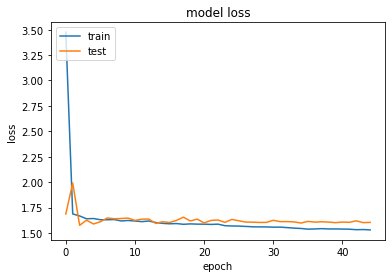

In [7]:
# summarize history for loss
history=h
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [69]:
BCL=[]
for i,p in enumerate(y_pred):
    if(p==1):
        BCL.append(DB_c[i])
print(len(BCL))
i=15
saveobj("ch{0}/BCL29.dictionary".format(i),BCL)

10


In [23]:
y=SS
y

[array([[ 2.0944204 ,  0.7343619 ],
        [ 2.7888572 ,  0.682957  ],
        [ 2.4754608 ,  0.39624166],
        [ 1.9589406 , -0.35089982],
        [ 2.1714048 ,  0.47027677],
        [ 2.38188   ,  0.8893176 ],
        [ 2.1858795 ,  0.87145436],
        [ 1.8950516 ,  0.81917816],
        [ 1.6558878 ,  0.7949881 ],
        [ 1.4681236 ,  0.7735581 ],
        [ 1.3261917 ,  0.75293237],
        [ 1.1558357 ,  0.6805368 ]], dtype=float32)]

In [26]:
y[0][0] #list t
y[0][2][1]

0.39624166

In [17]:
#from LSTM.LSTMretrain import retrain
#model = load_model('./LSTM/output_files/model_482-1.85.h5')
#retrain(trainseq[:5],param,model)

###################################### UCAD multi THREAD #######################
###############################################################################

In [16]:
print("======== ThreadPoolExecutor Parallel research for a sequence in the chronicle database  =======")
def UCADTHpred(seqs):
    start_time = time.perf_counter()
    predict=syn(DB_ch,seqs,5)
    end_time=time.perf_counter()
    e=end_time - start_time
    return predict ,e
predict,e=UCADTHpred(list(seq_df.sequence))
mu=np.mean(memory_usage((UCADTHpred,(seq_df.sequence.tolist(),))))
print(predict)

======== ThreadPoolExecutor Parallel research for a sequence in the chronicle database  =======
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.9231, 0.9231, 0.8869, 0.8869, 0.9608, 0.9231, 0.7866, 0.8187, 0.7866, 0.9231, 0.1108, 0.0872, 0.0518, 0.0944, 0.0539, 0.0944, 0.3679, 0.0659, 0, 0]


0.75 1.0


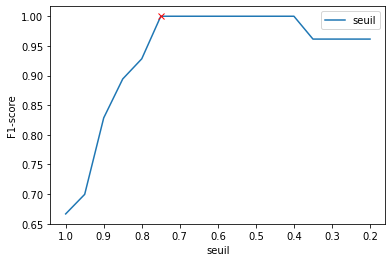

In [17]:
ss,fl,f,seuil=learn_threshold(predict,seq_df.label)
print(seuil,f)
plot_threshold(ss,fl,f,seuil)

In [18]:
y_pred=decision(predict,seuil)
print(y_pred)

assert(len(seq_df)==len(y_pred))
# Display the confusion matrix
print(metrics.confusion_matrix(seq_df.label, y_pred))
# Calculate the classification rate of this classifier
p=metrics.accuracy_score(seq_df.label, y_pred)
r=metrics.recall_score(seq_df.label, y_pred, average='macro')
f1=metrics.f1_score(seq_df.label, y_pred, average='macro')
p1,r1,f,_=metrics.precision_recall_fscore_support(seq_df.label, y_pred, average='micro')
print(f1,r,p)
savescore("UCADTH.csv",p,r,f1,e,mu)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[10  0]
 [ 0 20]]
1.0 1.0 1.0
